<a href="https://www.kaggle.com/code/dascient/uacp-defining-powellscore-veracity-variables?scriptVersionId=131761298" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# UACP - Defining PowellScore & Veracity Variables

## [NLP - Sentiment Intensity Analyzer](https://github.com/cjhutto/vaderSentiment) Against Reporting Comments
​
Here we isolate only pertinent variables from the original dataset. For the sake of computational efficiency, we only use 500 samples from the reports. We've also decided to leave open most of the code cells below; enabling transparency on foundation of both variables. 

In [8]:
# for the sake of expeditious analysis
import warnings
warnings.filterwarnings("ignore")
from IPython.display import clear_output
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from matplotlib import pyplot as plt
from shapely.geometry import Point
import geopandas as gpd
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from geopandas import GeoDataFrame
import matplotlib.colors as colors
import seaborn as sns
import random as r

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        #print('Files loaded.')
        
# loading first nuforc dataframe
og_df1 = pd.read_csv('/kaggle/input/ufo-sightings/ufos.csv',header=0)
df = og_df1.dropna().copy()
og_df2 = pd.read_csv('/kaggle/input/d/NUFORC/ufo-sightings/scrubbed.csv',header=0)
df2 = og_df2.dropna().copy()

#############################################
# sanitize
# drop some columns, for now
df = df.drop(columns=['datetime','duration (hours/min)'])

# date posted deemed to be easily conveible to timestamp values, so i'm gonna work with that for now.
df['date posted'] = df['date posted'].astype('datetime64[ns]')


# length of comments
df['comment_length'] = [len(str(v[0:500])) for i,v in df.comments.items()]


# convert seconds to minutes
df["duration (minutes)"] = [int(v)/60 for i,v in df["duration (seconds)"].items()]


# creating Geo Point column for sopecial use below
df['Geo Point'] = df.apply(lambda x:'%s, %s' % (x['latitude'],x['longitude']),axis=1)


# let's create subsets of our 80,000 here: 
# we can implement conditionals, remove/analyze outliers, 
# & will enable for back referencing when starting to run 
# robust AI-ML modeling that would otherwise take much longer to run.

# let's create subsets from the main dataframe/reporting-data w/ respect to duration of observations
df_under100 = df[df["duration (minutes)"]<100]
df_under60 = df[df["duration (minutes)"]<60]

# random binary column for future AI-ML modeling.
a=['balloon','spacejunk','sensor_malfunction','undentified','anomalous']     
df['verified'] = pd.Series(r.choices(a,k=len(df),weights=(50, 40, 30, 20, 10)),index=df.index)

# shape-focused
circles = df[df['shape'] == 'circle']
spheres = df[df['shape'] == 'sphere']
lights = df[df['shape'] == 'light']
teardrops = df[df['shape'] == 'teardrop']

# year-month
df['year_month'] = df['date posted'].dt.to_period('M')

# ca_oval
ca_oval = df[df.state=='ca'].reset_index(drop=True)
ca_oval = ca_oval[ca_oval['shape']=='oval']


# show
print("Our dataset(s).")
print(f"\nReports: {len(df)} non-null dataframe.")
print("\nMatrix:",df.shape[0],"rows,",df.shape[1],"columns")
df = df.sort_values('date posted',ascending=True).reset_index(drop=True)
df.tail(11).reset_index(drop=True).style.background_gradient(cmap ='seismic').set_properties(**{'font-size': '11px'})

/kaggle/input/ufo-sightings/ufos.csv
/kaggle/input/d/NUFORC/ufo-sightings/complete.csv
/kaggle/input/d/NUFORC/ufo-sightings/scrubbed.csv
Our dataset(s).

Reports: 66516 non-null dataframe.

Matrix: 66516 rows, 14 columns


,city,state,country,shape,duration (seconds),comments,date posted,latitude,longitude,comment_length,duration (minutes),Geo Point,verified,year_month
0,henderson,nv,us,fireball,20.000000,"Very Strange Red Sphere Over Henderson, Nevada.",2014-05-08 00:00:00,36.039722,-114.981111,50,0.333333,"36.0397222, -114.9811111",undentified,2014-05
1,waxhaw,nc,us,circle,60.000000,Bright orb that rapidly traveled west leaving a light trail and vanishing.,2014-05-08 00:00:00,34.924444,-80.743611,74,1.000000,"34.9244444, -80.7436111",undentified,2014-05
2,mount hope (canada),on,ca,teardrop,2700.000000,"Shell shaped object twitching it's way up in the sky, same time every other night.",2014-05-08 00:00:00,43.140000,-79.900000,88,45.000000,"43.14, -79.9",balloon,2014-05
3,atkinson,nh,us,sphere,300.000000,Flashlight made UFO disappear,2014-05-08 00:00:00,42.838333,-71.147500,29,5.000000,"42.8383333, -71.1475",balloon,2014-05
4,lombard,il,us,circle,20.000000,Bright red & yellow colored ball flying west to east in a straight line.,2014-05-08 00:00:00,41.880000,-88.007778,76,0.333333,"41.88, -88.0077778",balloon,2014-05
5,waxhaw,nc,us,circle,60.000000,Bright orb that dimmed & got smaller before vanishing in the sky.,2014-05-08 00:00:00,34.924444,-80.743611,69,1.000000,"34.9244444, -80.7436111",balloon,2014-05
6,hialeah,fl,us,light,120.000000,My wife stepped outside to get some laundry and she noticed a bright orange light hovering in the sky and called me to come out and see,2014-05-08 00:00:00,25.857222,-80.278333,135,2.000000,"25.8572222, -80.2783333",balloon,2014-05
7,grayson,ga,us,sphere,20.000000,"On May 3 around 9 pm I was studying Mars with an outdoor telescope on a clear night when a perfectly round , bright light appeared Sout",2014-05-08 00:00:00,33.894167,-83.955833,138,0.333333,"33.8941667, -83.9558333",balloon,2014-05
8,currie,nc,us,light,120.000000,Brilliantly Lit Flying Object With Reddish Orange Lights.,2014-05-08 00:00:00,34.462500,-78.101389,57,2.000000,"34.4625, -78.1013889",spacejunk,2014-05
9,kuna,id,us,circle,600.000000,"Bright Orange light(orbs) 1 multiplied to 8, Moving in all directions and weird patterns went on for 10 minutes until disappered. Loud",2014-05-08 00:00:00,43.491944,-116.419167,137,10.000000,"43.4919444, -116.4191667",spacejunk,2014-05


In [10]:
# https://www.geeksforgeeks.org/python-sentiment-analysis-using-vader/
# https://github.com/cjhutto/vaderSentiment
# import SentimentIntensityAnalyzer class
# from vaderSentiment.vaderSentiment module.

from nltk.sentiment.vader import SentimentIntensityAnalyzer

# function to print sentiments
# of the sentence.
def sentiment_scores(sentence):

    # Create a SentimentIntensityAnalyzer object.
    sid_obj = SentimentIntensityAnalyzer()
    sentiment_dict = sid_obj.polarity_scores(sentence)
    
    # create a list
    results = []
    results.append({"% Positive":sentiment_dict['pos']*len(sentence),
                    "% Negative":sentiment_dict['neg']*len(sentence),
                    "% Neutral":sentiment_dict['neu']*len(sentence)
                   })
    results = pd.DataFrame(results)
    return results

# Apply to df['comments'] column.
def NLP_PowellScore(commentsColumns):
    
    # obtain each comment for 'comments' column
    eachComment = [eachComment for i,eachComment in commentsColumns.items()]
    eachComment = pd.Series(eachComment)
                               
    # vader.variables.PowellScore
    PowellPositive = [v for v in list([sentiment_scores(sentimentAnalyzedComment)["% Positive"][0] for i,sentimentAnalyzedComment in eachComment.items()])]
    PowellNegative = [v for v in list([sentiment_scores(sentimentAnalyzedComment)["% Negative"][0] for i,sentimentAnalyzedComment in eachComment.items()])]
    PowellNeutral = [v for v in list([sentiment_scores(sentimentAnalyzedComment)["% Neutral"][0] for i,sentimentAnalyzedComment in eachComment.items()])]
    
    return PowellPositive,PowellNegative,PowellNeutral

### Sample of 500 reports sorted by Veracity

In [11]:
# defining Powell Scores by sentiment outputs: Positive, Negative, Neutral.

# let's only take a small sample - this will definitely take a few minutes, grab yourself some water...
robert = df.sample(500).copy()

robert["PowellPositive"] = NLP_PowellScore(robert['comments'])[0]
robert["PowellNegative"] = NLP_PowellScore(robert['comments'])[1]
robert["PowellNeutral"] = NLP_PowellScore(robert['comments'])[2]

# PowellScore 
robert["PowellScore"] = (robert["PowellPositive"]-robert["PowellNegative"])/robert["PowellNeutral"]

# veracity
robert["veracity"] = robert["PowellScore"]*robert["comment_length"] # can incorporate lexicon analyses in place of the latter multiple.

columns = ['date posted','city','state','shape','comments','comment_length',\
        'latitude','longitude','PowellPositive',\
        'PowellNegative','PowellNeutral','PowellScore','veracity']

robert[columns].sort_values('veracity',ascending=False).head(20).reset_index(drop=True)\
        .style.background_gradient(cmap ='seismic').set_properties(**{'font-size': '11px'})

,date posted,city,state,shape,comments,comment_length,latitude,longitude,PowellPositive,PowellNegative,PowellNeutral,PowellScore,veracity
0,2008-04-17 00:00:00,new york city (brooklyn),ny,sphere,A clear bright starry night. Very nice indeed with great air quality that night.I was on duty and doing guard. The premises are outdoor,135,40.714167,-74.006389,54.000000,0.000000,81.000000,0.666667,90.000000
1,2004-07-25 00:00:00,chicago,il,fireball,brilliant beautiful orb over lake,33,41.850000,-87.650000,23.760000,0.000000,9.240000,2.571429,84.857143
2,2003-08-28 00:00:00,banff (canada),ab,cross,((NUFORC Note: Mars sighting?)) Curious bright pulsing light.,63,51.166667,-115.566667,29.232000,0.000000,33.768000,0.865672,54.537313
3,2008-01-21 00:00:00,centreville,md,other,just above the treeline i saw a silver globe (not perfectly shaped) it had a heat type haze around it. it was perfectly still and was,134,39.041667,-76.066667,38.324000,0.000000,95.676000,0.400560,53.675070
4,2004-01-31 00:00:00,columbia,ct,cylinder,"Missle seen heading South, over Connecticut, on a clear bright day. 8:35 am.",82,41.701944,-72.301667,29.110000,0.000000,52.890000,0.550388,45.131783
5,2004-06-04 00:00:00,tracy,ca,disk,15 meters brilliant silver object slowly floats then zips away on a clear day - gone in a fraction of second,109,37.739722,-121.424167,31.174000,0.000000,77.826000,0.400560,43.661064
6,2010-11-21 00:00:00,fort worth,tx,circle,"Very bright twin planet-like lights appearing to E/SE of Fort worth, TX that faded out very fast.",100,32.725278,-97.320556,30.000000,0.000000,70.000000,0.428571,42.857143
7,2013-05-15 00:00:00,upper lake,ca,light,Very bright red light Hovering in the south horizon.glow very bright red then dim out and random secondary flashes of red,121,39.164722,-122.909444,30.492000,0.000000,90.508000,0.336898,40.764706
8,2009-06-09 00:00:00,oakland,ca,light,"Clear blue sky on Sunday morning. Very bright light at high altitude, probably about 6x brighter than Venus, but not larger than a very",141,37.804444,-122.269722,31.302000,0.000000,109.698000,0.285347,40.233933
9,2003-08-28 00:00:00,weston,co,light,Bright star like light with blue and red lights shining downward while moving quickly in zig-zag patterns.,106,37.132778,-104.848333,28.090000,0.000000,77.910000,0.360544,38.217687


## Ovals seen between Imperial Beach & Blythe, California

In [13]:
# only ovals
ca_oval_162 = ca_oval.sort_values(['latitude','longitude']).head(45)
robert_ca_oval_162 = ca_oval_162
robert_ca_oval_162["PowellPositive"] = NLP_PowellScore(robert_ca_oval_162['comments'])[0]
robert_ca_oval_162["PowellNegative"] = NLP_PowellScore(robert_ca_oval_162['comments'])[1]
robert_ca_oval_162["PowellNeutral"] = NLP_PowellScore(robert_ca_oval_162['comments'])[2]

# PowellScore 
robert_ca_oval_162["PowellScore"] = (robert_ca_oval_162["PowellPositive"]-robert_ca_oval_162["PowellNegative"])/robert_ca_oval_162["PowellNeutral"]

# veracity
robert_ca_oval_162["veracity"] = robert_ca_oval_162["PowellScore"]*robert_ca_oval_162["comment_length"] # can incorporate lexicon analyses in place of the latter multiple.


robert_ca_oval_162[['date posted','city','state','shape','comments','comment_length','duration (minutes)',\
        'latitude','longitude','PowellPositive','PowellScore','veracity']].sort_values(['date posted','latitude','longitude'],ascending=True).reset_index(drop=True)\
        .style.background_gradient(cmap ='seismic').set_properties(**{'font-size': '11px'})

,date posted,city,state,shape,comments,comment_length,duration (minutes),latitude,longitude,PowellPositive,PowellScore,veracity
0,1998-11-01 00:00:00,san marcos,ca,oval,"Friend and I were driving down the highway...moderate traffic. I noticed the aircraft first, it was hoovering over the freeway about 30",138,10.000000,33.143333,-117.165278,27.048000,0.243781,33.641791
1,1999-04-26 00:00:00,escondido,ca,oval,I glanced up and saw a small white oval traveling very rapidly across the sky. I ran outside to get a better look as I had been looking,135,0.016667,33.119167,-117.085556,15.660000,0.131222,17.714932
2,1999-10-19 00:00:00,san diego (u. s. naval base),ca,oval,were on lunch break from navy school. saw a small white cloud and then a object caom out of it. then another came out. then flew straig,135,15.000000,32.715278,-117.156389,0.000000,0.000000,0.000000
3,2000-03-16 00:00:00,san diego,ca,oval,"Already left message on answering machine. My son was out jogging about a block and a half from our home,and stopped in his tracks whe",138,2.000000,32.715278,-117.156389,0.000000,-0.228501,-31.533170
4,2000-09-21 00:00:00,san diego,ca,oval,"I went into my backyard to shut a gate. as i was walking i was looking at the night s sky, and to my surprise i saw an oval shaped dis",138,0.500000,32.715278,-117.156389,11.040000,0.086957,12.000000
5,2000-12-02 00:00:00,san diego,ca,oval,"A ballon-like small derigible looking object moved in a straight path, unaffected by wind currents, at a constant speed of about 5 mph",140,10.000000,32.715278,-117.156389,13.300000,0.104972,14.696133
6,2001-03-06 00:00:00,san diego,ca,oval,"I saw an huge glowing UFO with my mother and neighbors hovering over our backyard; when I was about 20, which moved at light speed.",134,15.000000,32.715278,-117.156389,12.730000,0.104972,14.066298
7,2001-08-05 00:00:00,san diego,ca,oval,"My 2nd UFO sighting, October 1979",36,3.000000,32.715278,-117.156389,0.000000,0.000000,0.000000
8,2002-01-11 00:00:00,vista,ca,oval,"helicopter shaped craft, many lights, no chopper blades, 10pm san diego california. 12-18-01.",102,0.416667,33.200000,-117.241667,0.000000,-0.183432,-18.710059
9,2003-04-22 00:00:00,pacific beach,ca,oval,Mystery craft scares Pacific Beach residents,44,30.000000,32.797778,-117.239444,0.000000,-0.479290,-21.088757


## Powell Variables in 3D
This is a 3D-interactive chart that uses the date posted, veracity, & PowellScore variables. Colored by comments. Sized by comment_length.

By definition, these actually render 5-Dimensional charts, if one considers veracity & commenth lengths of reports as 'features of a situation'.

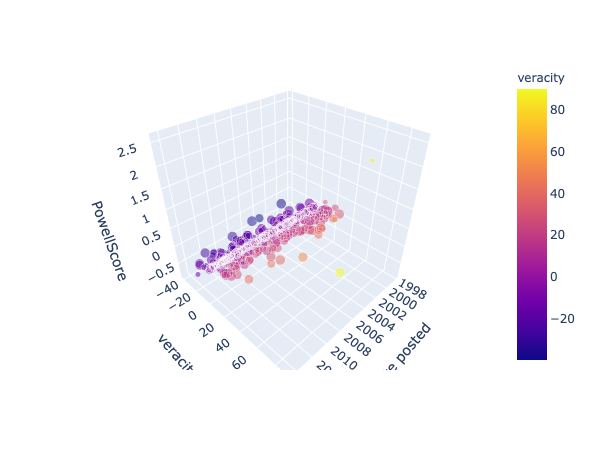

In [14]:
import plotly.express as px
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)

# graph
fig = px.scatter_3d(robert, x='date posted', y='veracity', z='PowellScore',
              color='veracity',
              size = 'comment_length',
              hover_name = 'city',
              hover_data=['city','state','comments'],              
              opacity=0.5,
              size_max=17
                   )
fig.show()

### This one shows Date Posted vs PowellScore & PowellPositive Variables.

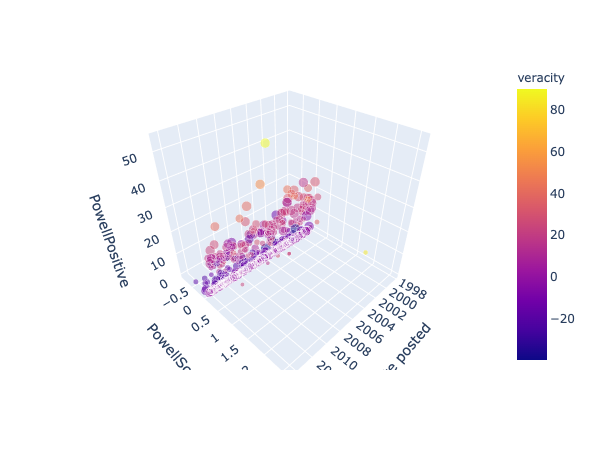

In [15]:
import plotly.express as px
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)

# graph
fig = px.scatter_3d(robert, x='date posted', y='PowellScore', z='PowellPositive',
              color='veracity',
              size = 'comment_length',
              hover_name = 'city',
              hover_data=['city','state','comments'],              
              opacity=0.5,
              size_max=17
                   )
fig.show()

### Ovals seen between Imperial Beach & Blythe, California - Date Posted vs PowellNeutral vs PowellScore

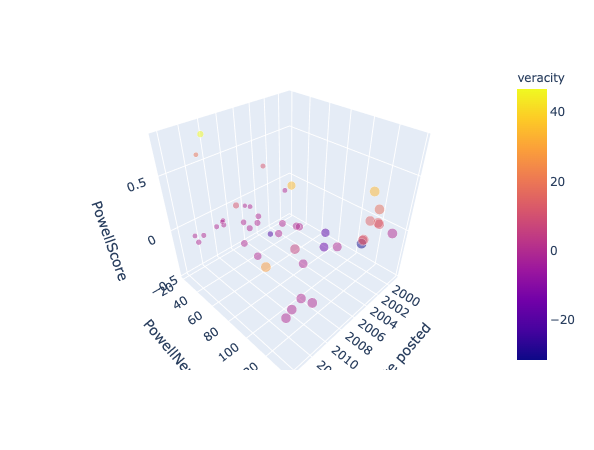

In [16]:
import plotly.express as px
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)

# graph
fig = px.scatter_3d(robert_ca_oval_162, x='date posted', y='PowellNeutral', z='PowellScore',
              color='veracity',
              size = 'comment_length',
              hover_name = 'city',
              hover_data=['city','state','comments','shape'],              
              opacity=0.5,
              size_max=17
                   )
fig.show()

These variables are still very much in progress & there currently is no process for defining them. Despite the disparate, disconnected, & wide range of skeptic/non-skeptic relational databases — we have managed to connect with organizations that promote open source — public repositories & most are willing to coordinate with one another in developing a UAP Reporting & Events Hub. Wherein all pertinent reports, sightings, measurements, & signatures are to be populated by various factors from multiple disciplines & technologies. We will do our best to coordinate with prominent key members of the UAP community in order to contribute to building out a “standardized” reporting mechanism in an intelligible & non-duplicative fashion. We are looking for ways forward in getting access to real-time, current reports.

The goal would be to create something similar to an Order of Battle, so that reports at specific times & locations can be compared to past reports to augment credibility determination, as well as eventually be compared to known events that may explain them. Once those explanations are vetted, reports would be coded by likelihood of mundane vs anomalous, which would aid in the processing of similar events in the future.

In addition, we have already begun looking for trends over time, such as the time of day when reported events take place, & the type of object reported over the decades. The latter can be observed in the “Shapes by Share of Reports” chart, which provides indications of confirmation bias in observed behavior.

Finally, big data analysis (alongside robust AI|ML|DS modeling techniques) could also provide insight into the development of improved collection & reporting processes, which currently appear to be undefined, improving the quality of the data we receive. — K. Kolbe.